# Introduction

Nous sommes engagés dans un projet visant à examiner les facteurs qui influencent le taux de rotation des employés chez HumanForYou, une entreprise pharmaceutique indienne. Avec un taux de rotation annuel d'environ 15 %, nous cherchons à identifier les causes sous-jacentes et à élaborer des stratégies pour le diminuer. Ce taux élevé de rotation présente plusieurs désavantages pour l'entreprise, y compris des retards dans les projets, la nécessité d'un service des ressources humaines important pour le recrutement, et le temps consacré à la formation des nouveaux employés jusqu'à ce qu'ils atteignent leur pleine productivité.

Pour atteindre cet objectif, l'entreprise nous a fourni plusieurs ensembles de données anonymisées contenant des informations sur les employés, leurs évaluations par les managers, leur satisfaction au travail, et leurs horaires de travail pour l'année 2015. Ces données englobent une variété d'aspects tels que l'âge, le sexe, le niveau d'éducation, le domaine d'étude, le salaire mensuel, le nombre d'années passées dans l'entreprise, ainsi que la satisfaction vis-à-vis de l'environnement de travail, du poste occupé, et de l'équilibre travail-vie personnelle.

Notre mission en tant qu'analystes de données comprend plusieurs étapes clés :

1. Générer et justifier le traitement des jeux de données pour aborder la problématique.
2. Sélectionner et justifier les algorithmes d'intelligence artificielle à utiliser.
3. Analyser et interpréter les résultats obtenus à l'aide de ces algorithmes, en s'appuyant sur des métriques adéquates.
4. Proposer une démarche pour améliorer les modèles d'IA développés.
5. Déterminer le modèle final en fonction des besoins spécifiques de l'entreprise et des analyses effectuées.
6. Émettre des recommandations basées sur l'analyse pour aider l'entreprise à réduire son taux de rotation.

Nous sommes attendus pour présenter nos résultats et recommandations à travers une présentation intégrant un notebook Jupyter, démontrant l'ensemble de notre démarche analytique et les conclusions que nous avons tirées.







# Préparation des données
## Préparation de l'environnement

In [232]:
# Importations standard et pour la manipulation des données
import os
import pandas as pd
import numpy as np
from datetime import datetime
from cmath import phase, rect
from math import radians, degrees

# Importations pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importations pour le machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Configuration de Seaborn pour les visualisations
sns.set(style="whitegrid")

# Ignorer les avertissements inutiles pour nettoyer la sortie
import warnings
warnings.filterwarnings("ignore")


## Import des données
Cinq ensembles de données sont chargés en utilisant la fonction pd.read_csv() de la bibliothèque pandas, une bibliothèque puissante pour la manipulation et l'analyse des données en Python. Chaque fichier CSV est lu et stocké dans un DataFrame pandas distinct, ce qui permet une manipulation aisée des données pour l'analyse ultérieure. Les DataFrames créés sont :

- general contenant les données générales sur les employés (fichier general_data.csv).
- employe contenant les résultats de l'enquête sur les employés (fichier employee_survey_data.csv).
- manager contenant les résultats de l'enquête sur les managers (fichier manager_survey_data.csv).
- In contenant les données sur les horaires d'arrivée des employés (fichier in_time.csv).
- Out contenant les données sur les horaires de départ des employés (fichier out_time.csv).

In [207]:
path = "./datasets/"

general = pd.read_csv(path + "general_data.csv")
employe = pd.read_csv(path + "employee_survey_data.csv")
manager = pd.read_csv(path + "manager_survey_data.csv")
In = pd.read_csv(path + "in_time.csv")
Out = pd.read_csv(path + "out_time.csv")

## Manipulation des fichiers des horaires de travail

Nous allons travailler sur les fichiers concernant les horaires de travail afin de les rendre utilisables.

D'abord, nous changeons les NaN en 0 (ce qui correspond donc aux jours de congés) puis on vérifie que le nombre de jours de congés est bien le même dans les deux tables. On affiche ensuite un histogramme afin d'en retirer un aperçu plus visuel.

In [208]:
In.fillna(0, inplace=True)
Out.fillna(0, inplace=True)
vac_In = (In == 0).astype(int).sum(axis=1)
vac_Out = (Out ==0).astype(int).sum(axis=1)
 
vac_In.equals(vac_Out)

True

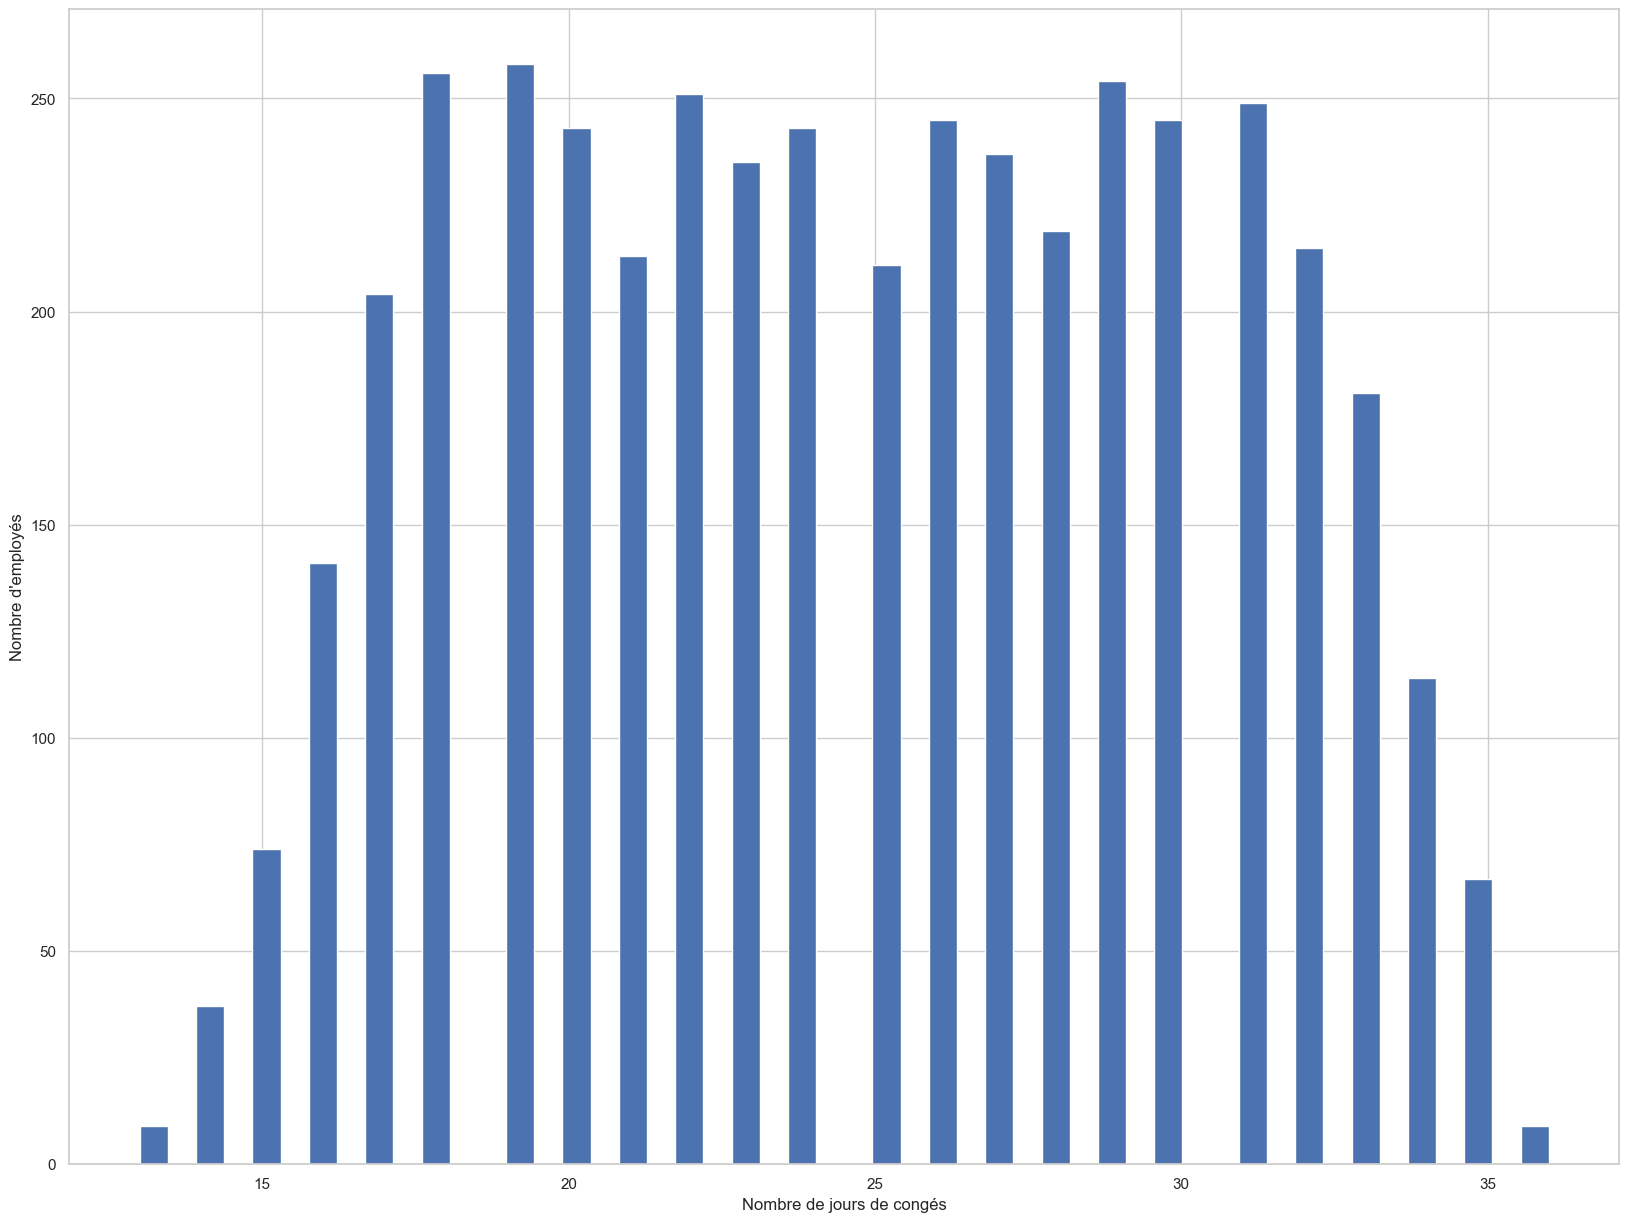

In [209]:
vac_In.hist(bins=50, figsize=(20,15))
plt.xlabel("Nombre de jours de congés")
plt.ylabel("Nombre d'employés")
plt.show()

On supprime la première colonne des deux tableaux car elles sont inutiles.

In [210]:
In = In.drop(In.columns[0], axis = 1)
Out = Out.drop(Out.columns[0], axis = 1)

Nous avons traité et analysé les données relatives aux horaires d'arrivée et de départ des employés en convertissant les données en format datetime, en gérant les erreurs pour remplacer les valeurs inappropriées par NaT. 

Nous avons défini deux fonctions essentielles : mean_angle pour calculer la moyenne des angles, facilitant la moyenne des temps en considérant ces derniers comme des vecteurs sur un cercle de 24 heures, et mean_time pour déterminer le temps moyen d'arrivée ou de départ, en excluant les valeurs manquantes. Cette dernière convertit les temps en secondes, calcule leur moyenne angulaire pour gérer correctement le passage de minuit, puis reconvertit cette moyenne en heures, minutes et secondes. Nous avons ensuite appliqué mean_time aux ensembles de données d'arrivée et de départ pour obtenir l'heure moyenne d'arrivée (AverageInTime) et de départ (AverageOutTime), nous permettant d'avoir une vue d'ensemble précise des tendances horaires des employés, essentielle pour comprendre leur comportement de travail et identifier d'éventuels liens avec la satisfaction ou le taux de rotation.







In [233]:
In_h = In.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))
Out_h = Out.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))

def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

def mean_time(row):
    row = row.dropna()  # Supprimer les valeurs NaT
    if row.empty:
        return None  # Retourner None ou une valeur par défaut si la ligne est vide après la suppression des NaT
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    if not seconds:
        return None  # Retourner None ou une valeur par défaut si aucun second n'est > 0
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
Out_h['AverageOutTime'] = Out_h.apply(mean_time, axis=1)  # Correction du nom de colonne pour AverageOutTime


In [212]:
In_h['AverageInTime'].head()

0    10:00:05
1    09:59:17
2    10:01:30
3    09:58:54
4    09:59:54
Name: AverageInTime, dtype: object

Nous calculons ensuite la durée moyenne de travail quotidien des employés en soustrayant l'heure moyenne d'arrivée (Average_In) de l'heure moyenne de départ (Average_Out).

In [213]:
Average_Out = pd.to_timedelta(Out_h['AverageOutTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = (Average_Out - Average_In)

print(AverageTimeWorking)

0      0 days 07:22:25
1      0 days 07:43:08
2      0 days 07:00:47
3      0 days 07:11:37
4      0 days 08:00:21
             ...      
4405   0 days 08:31:20
4406   0 days 06:05:34
4407   0 days 07:42:24
4408   0 days 09:29:34
4409   0 days 06:59:20
Length: 4410, dtype: timedelta64[ns]


## Fusion des données et nettoyage

On peut maintenant fusionner les csv restant et ajouter deux nouvelles colonnes : la première correspondant au nombre de jours de congés pris par l'employé, et la seconde au temps de travail moyen par jour de l'employé.

In [214]:
combined = general.merge(manager, how='right', on = 'EmployeeID')
combined_csv = combined.merge(employe, how='right', on = 'EmployeeID')
#On transforme tous les NA en 0
combined_csv.fillna(0, inplace=True)
combined_csv['AverageTimeWorking'] = AverageTimeWorking
combined_csv['Holidays'] = vac_In

combined_csv

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3,3,3.0,4.0,2.0,0 days 07:22:25,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,4,3.0,2.0,4.0,0 days 07:43:08,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,3,2.0,2.0,1.0,0 days 07:00:47,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,2,3,4.0,4.0,3.0,0 days 07:11:37,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,3,3,4.0,1.0,3.0,0 days 08:00:21,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,3,3,4.0,1.0,3.0,0 days 08:31:20,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,2,3,4.0,4.0,3.0,0 days 06:05:34,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,3,4,1.0,3.0,3.0,0 days 07:42:24,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,2,3,4.0,1.0,3.0,0 days 09:29:34,20


On remarque que le temps de travail moyen n'est pas dans un format manipulable, nous allons donc le transofrmer en float.

In [215]:
Time_float = combined_csv['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
print(Time_float)
combined_csv['AverageTimeWorking'] = Time_float

0       7.373611
1       7.718889
2       7.013056
3       7.193611
4       8.005833
          ...   
4405    8.522222
4406    6.092778
4407    7.706667
4408    9.492778
4409    6.988889
Name: AverageTimeWorking, Length: 4410, dtype: float64


Nous pouvons utiliser la méthode .info() sur notre datafrae pour obtenir un résumé concis.

In [216]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Pour notre projet, il serait judicieux d'examiner si certains employés sont surchargés de travail tandis que d'autres ont une charge de travail moins importante. Nous pourrions enrichir notre analyse en ajoutant une colonne qui catégoriserait chaque employé selon sa charge de travail : normale, faible, ou excessive. Cela apporterait une dimension supplémentaire à notre étude sur les facteurs influençant le taux de rotation au sein de l'entreprise.

In [246]:
combined_csv['AverageTimeWorking'].describe()

count    4410.000000
mean        7.700789
std         1.340222
min         5.950556
25%         6.673333
50%         7.406667
75%         8.368611
max        11.031389
Name: AverageTimeWorking, dtype: float64

Les données révèlent en effet des disparités significatives dans le temps de travail moyen des employés. Certains affichent un temps de travail moyen inférieur à 7 heures, ce qui peut être considéré comme relativement faible. À l'opposé, d'autres employés dépassent les 8 heures de travail moyen, atteignant même jusqu'à 11 heures, ce qui suggère une situation de surmenage.

Nous allons élaborer une fonction destinée à générer une liste peuplée de booléens, où le chiffre 0 indiquera que l'employé travaille moins que la norme, 1 signifiera que son volume de travail est standard, et 2 révélera un état de surmenage.




In [248]:
WorkingTimeEval = []
for i in range (0, combined_csv.shape[0]):
    if combined_csv['AverageTimeWorking'][i] < combined_csv['StandardHours'][i] :
        WorkingTimeEval.append(0)
    elif (combined_csv['AverageTimeWorking'][i] >= combined_csv['StandardHours'][i]) and (combined_csv['AverageTimeWorking'][i] <= 9):
        WorkingTimeEval.append(1)
    elif combined_csv['AverageTimeWorking'][i] > 9 :
        WorkingTimeEval.append(2)

Maintenant que notre liste est complète, nous pouvons l'intégrer comme nouvelle colonne dans notre ensemble de données.

In [254]:
combined_csv['WorkingTimeEval'] = WorkingTimeEval
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Nous avons opté pour l'élimination de la colonne EmployeeCount de notre jeu de données, car cette colonne présente une valeur unique pour l'ensemble du dataset, ce qui la rend non pertinente pour notre analyse.

In [256]:
combined_csv['EmployeeCount'].value_counts()

EmployeeCount
1    4410
Name: count, dtype: int64

In [257]:
combined_csv = combined_csv.drop(columns=['EmployeeCount'])

In [258]:
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeID               4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4410 non-null   float64
 14  Over18                  

## Exploration des données

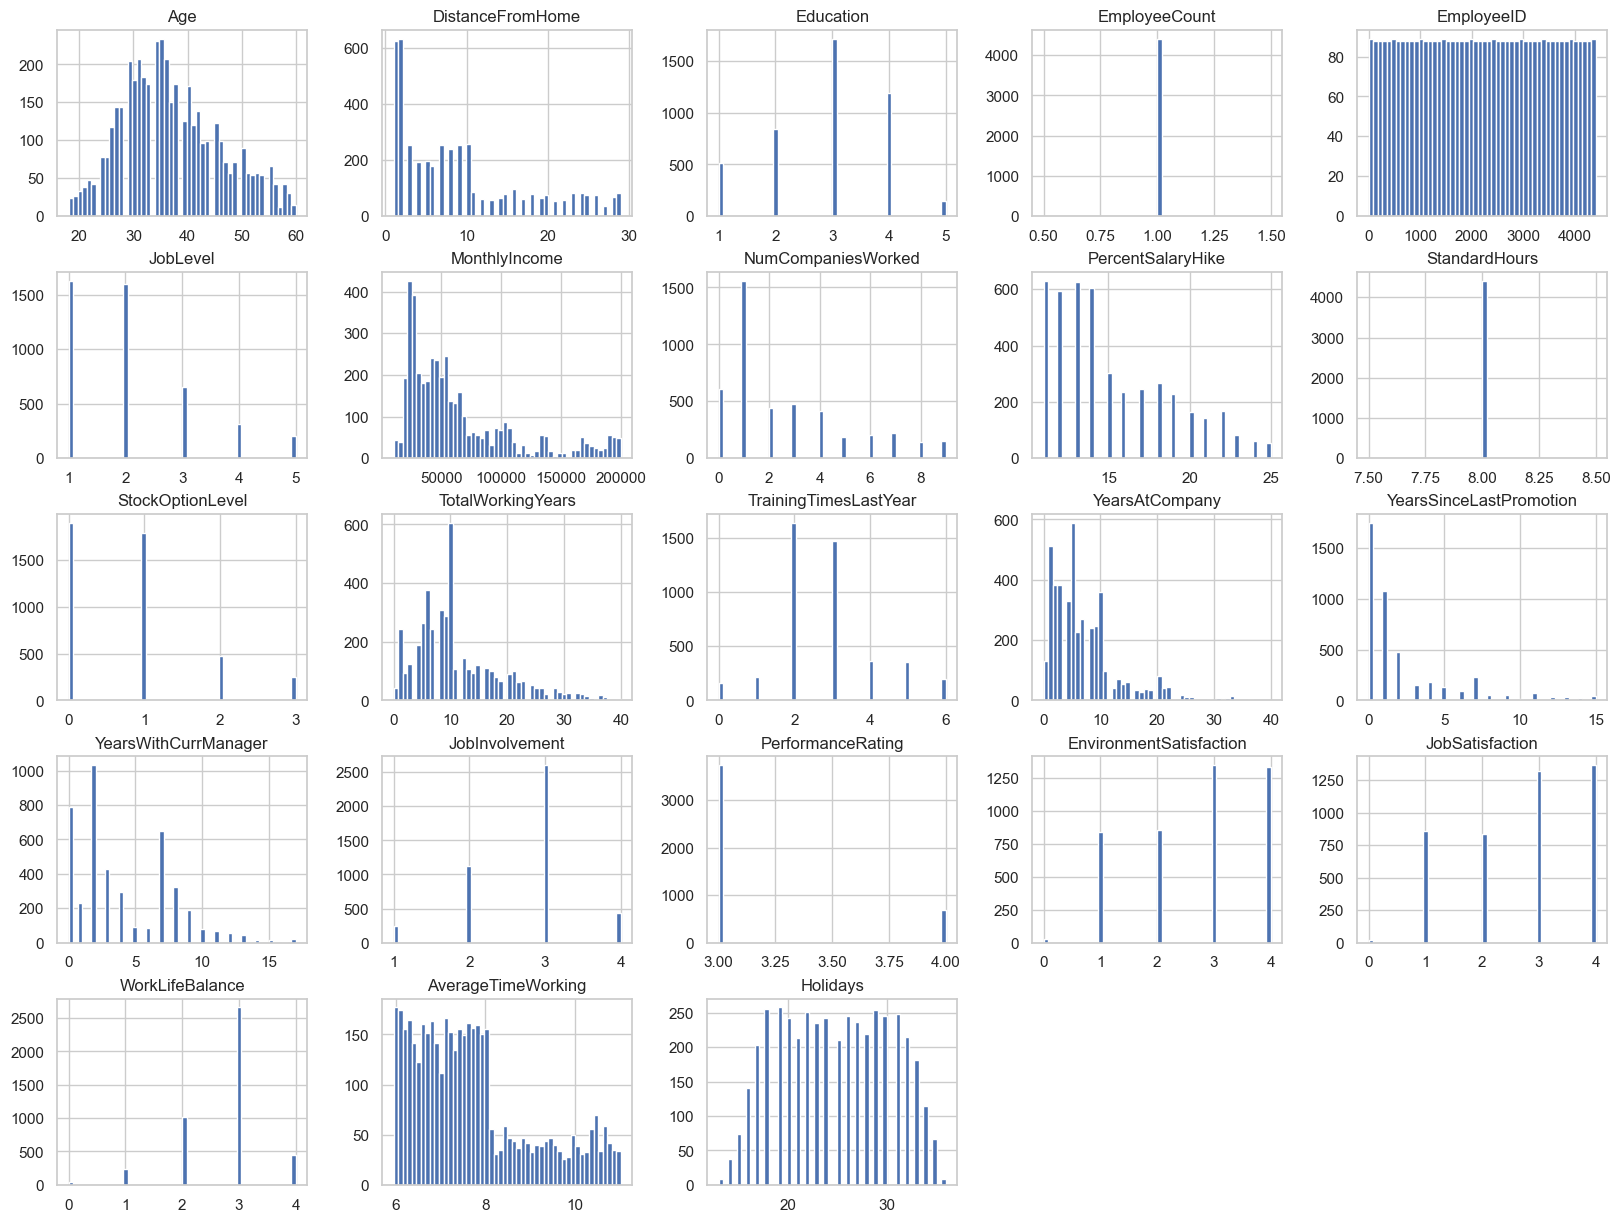

In [217]:
combined_csv.hist(bins=50, figsize=(20,15))
plt.show()

## Pipeline de transformation

Dans ce code, nous avons entrepris la préparation des données pour un modèle de machine learning, en identifiant d'abord les caractéristiques numériques et catégorielles nécessaires à la transformation. Les caractéristiques numériques (num_features) comprennent des variables telles que l'âge, le revenu mensuel, la distance domicile-travail, les années de travail totales, entre autres, tandis que les caractéristiques catégorielles (cat_features) incluent le voyage d'affaires, le département, le domaine d'éducation, etc.

Nous avons ensuite créé des pipelines séparés pour le traitement des caractéristiques numériques et catégorielles. Le pipeline numérique (num_pipeline) utilise un imputateur pour remplacer les valeurs manquantes par la moyenne et un normalisateur pour standardiser les caractéristiques. Le pipeline catégoriel (cat_pipeline), quant à lui, remplace les valeurs manquantes par la valeur la plus fréquente et applique un encodage one-hot pour gérer les variables catégorielles.

Ces pipelines sont combinés dans un transformateur de colonnes (ColumnTransformer), formant un préprocesseur complet qui effectue simultanément les transformations numériques et catégorielles sur les données.

Le dataset est ensuite divisé en caractéristiques (X) et cible (y), avec y étant binarisée pour refléter l'attrition comme une variable binaire (1 pour 'Yes', 0 pour 'No').

Nous vérifions enfin l'existence des colonnes référencées dans X pour s'assurer que toutes les colonnes nécessaires sont présentes, en affichant les colonnes manquantes le cas échéant. Cette étape est cruciale pour éviter les erreurs lors de l'application du préprocesseur sur le dataset, garantissant que les transformations sont appliquées correctement à toutes les caractéristiques spécifiées.

In [234]:
# Identification des colonnes pour chaque transformation
num_features = ['Age', 'MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 'NumCompaniesWorked', 'YearsAtCompany', 'Holidays', 'AverageTimeWorking']
cat_features = ['BusinessTravel','Department' , 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']

# Création des pipelines pour les transformations numériques et catégorielles
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assemblage du pipeline complet
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Division du dataset
X = combined_csv.drop('Attrition', axis=1)
y = combined_csv['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Conversion de la cible en binaire


# Vérifiez si toutes les colonnes référencées existent dans X
print(X.columns)
missing_cols_num = [col for col in num_features if col not in X.columns]
missing_cols_cat = [col for col in cat_features if col not in X.columns]
print("Colonnes numériques manquantes:", missing_cols_num)
print("Colonnes catégorielles manquantes:", missing_cols_cat)

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement',
       'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'AverageTimeWorking', 'Holidays'],
      dtype='object')
Colonnes numériques manquantes: []
Colonnes catégorielles manquantes: []


## Algorithmes de Machine Learning 
Notre pipeline de prétraitement des données est désormais prêt, intégrant soigneusement les transformations nécessaires pour les caractéristiques numériques et catégorielles. Cette étape cruciale nous permet d'assurer que les données sont correctement formatées et normalisées pour l'application des modèles d'apprentissage automatique. Avec cette préparation achevée, nous pouvons maintenant passer à la phase suivante de notre projet : la sélection et l'application des algorithmes de machine learning. 

## Méthode des k plus proches voisins (KNN)
La méthode des k plus proches voisins (KNN) est un algorithme d'apprentissage supervisé simple et intuitif utilisé pour la classification et la régression. Le principe de base de KNN est de trouver les k échantillons les plus proches (ou voisins) d'un point de données non classifié dans l'espace des caractéristiques et de prédire son étiquette (pour la classification) ou sa valeur (pour la régression) en se basant sur la majorité ou la moyenne des étiquettes ou valeurs de ces voisins. La distance entre les points de données, souvent calculée par la distance euclidienne, sert à déterminer les voisins les plus proches. L'efficacité de KNN dépend du choix de k (le nombre de voisins) et de la mesure de distance utilisée. Bien qu'il soit facile à comprendre et à mettre en œuvre, KNN peut devenir inefficace en termes de temps et de mémoire avec de grands ensembles de données, car il nécessite de calculer la distance à chaque point de données lors de la prédiction.

### Copie des données

In [220]:
dataSetKNN = combined_csv.copy()
dataSetKNN

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


In [237]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

### Entraienemnt du modèle

In [238]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', KNeighborsClassifier())])

### Prédicitons

In [239]:
# Prédictions sur l'ensemble de test
y_pred = knn_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8631897203325775

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      1115
           1       0.62      0.35      0.44       208

    accuracy                           0.86      1323
   macro avg       0.75      0.65      0.68      1323
weighted avg       0.84      0.86      0.85      1323



Les résultats obtenus avec l'algorithme des k plus proches voisins (KNN) pour notre projet de prédiction de l'attrition des employés indiquent une précision globale de 86.3%. Cette précision reflète la proportion d'employés correctement classés par le modèle par rapport à l'ensemble total des prédictions.

Dans le détail du rapport de classification, nous observons des performances variables entre les classes. Pour la classe 0 (employés restants), le modèle affiche une précision de 89%, un rappel de 96%, et un score F1 de 92%, indiquant une performance élevée dans l'identification des employés qui ne quittent pas l'entreprise. Cela suggère que le modèle est particulièrement efficace pour reconnaître les cas de non-attrition.

Cependant, pour la classe 1 (employés quittant l'entreprise), les performances sont nettement inférieures : une précision de 62%, un rappel de 35%, et un score F1 de 44%. Ces résultats montrent que, bien que le modèle soit relativement précis lorsqu'il prédit une attrition, il a tendance à ne reconnaître qu'une faible proportion des cas réels d'attrition (faible rappel), ce qui limite son efficacité pour identifier les employés à risque de départ.

Les scores macro et pondérés moyens fournissent un résumé des performances du modèle, avec un score moyen macro de 68% et un score moyen pondéré de 85%, reflétant l'équilibre entre les classes et la distribution des classes dans l'ensemble des données.

En résumé, bien que le modèle KNN montre une précision globale élevée, l'analyse détaillée révèle des limites, notamment dans la détection de l'attrition des employés. Cela souligne l'importance de considérer d'autres modèles ou d'ajuster les paramètres du KNN pour améliorer la sensibilité du modèle aux cas d'attrition.







### Matrice de confusion

La matrice de confusion montre les prédictions correctes et incorrectes du modèle en détail. Elle est particulièrement utile pour voir comment le modèle performe pour chaque classe.

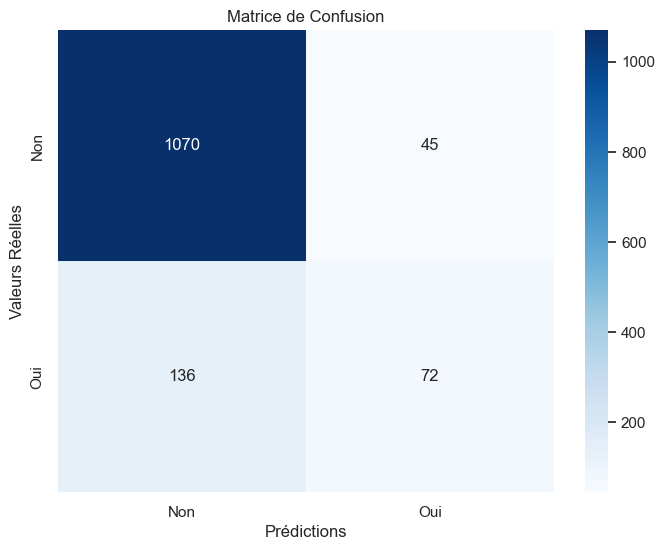

In [240]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

La matrice montre les résultats suivants :
- Vrais Négatifs (TN) : 1070 employés ont été correctement prédits comme ne quittant pas l'entreprise.
- Faux Positifs (FP) : 45 employés ont été incorrectement prédits comme quittant l'entreprise alors qu'ils sont restés.
- Faux Négatifs (FN) : 136 employés ont été incorrectement prédits comme restant alors qu'ils ont quitté l'entreprise.
- Vrais Positifs (VP) : 72 employés ont été correctement prédits comme quittant l'entreprise.

Le modèle a une forte tendance à correctement identifier les employés qui restent (TN élevé), mais il est moins performant pour identifier correctement ceux qui quittent l'entreprise (VP plus faible par rapport au FN). Le nombre élevé de FN indique que le modèle pourrait être amélioré pour mieux détecter les cas d'attrition. Les FP relativement bas indiquent que le modèle ne fait pas beaucoup d'erreurs en classant faussement les employés comme partants.

### ROC Curve

La courbe Receiver Operating Characteristic (ROC) et l'Area Under the Curve (AUC) évaluent la performance du modèle dans les tâches de classification binaire à différents seuils. Ces métriques sont utiles pour évaluer la capacité du modèle à distinguer entre les classes.

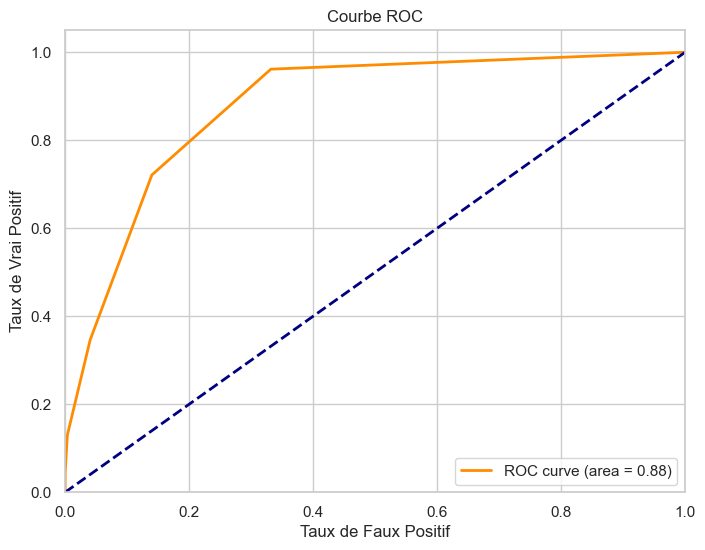

In [225]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, knn_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

 La courbe ROC évalue la capacité d'un modèle à discriminer entre les classes positives et négatives à différents seuils de classification. L'AUC varie entre 0 et 1, où une valeur de 0.5 suggère une performance équivalente à un classement aléatoire, et une valeur de 1 indique une capacité parfaite à distinguer entre les classes positives et négatives sans aucune erreur.

Avec une AUC de 0.88, cela signifie que le modèle a une très bonne capacité à différencier entre les employés qui vont quitter l'entreprise et ceux qui vont rester. Plus précisément, cette valeur indique que si nous choisissons au hasard un employé ayant quitté l'entreprise (positif) et un employé ayant choisi de rester (négatif), il y a 88% de chances que le modèle classe correctement l'employé partant avec une probabilité plus élevée de quitter l'entreprise que l'employé restant.

### Conclusion

Avec une précision globale de 86.3%, le modèle est généralement précis dans ses prédictions. Cependant, la matrice de confusion révèle certaines faiblesses, notamment avec un nombre relativement élevé de faux négatifs (136), où le modèle n'a pas réussi à identifier les employés qui ont effectivement quitté l'entreprise. Bien que le modèle ait correctement identifié un grand nombre de vrais négatifs (1070), indiquant une bonne capacité à reconnaître les employés qui restent, la capacité à détecter correctement les départs (72 vrais positifs contre 136 faux négatifs) est moins impressionnante. Cela suggère que le modèle pourrait être trop prudent dans la prédiction de l'attrition, ce qui pourrait être dû à un déséquilibre des classes dans les données d'entraînement où les cas de non-attrition sont beaucoup plus nombreux que les cas d'attrition.

La précision de 62% pour la classe d'attrition (employés quittant l'entreprise) et le rappel de 35% pour cette même classe reflètent ces limitations. Le modèle tend à manquer un certain nombre de vrais cas d'attrition, ce qui est problématique si l'objectif est d'intervenir ou de retenir ces employés. En revanche, une AUC de 0.88 indique que le modèle est assez bon pour classer un employé au hasard comme ayant plus de chances de quitter lorsque c'est effectivement le cas, comparé à un employé au hasard qui reste.

Dans l'ensemble, l'utilisation de KNN pour notre projet montre un potentiel prometteur mais avec des axes d'amélioration. Il peut être nécessaire d'ajuster le nombre de voisins k, d'expérimenter avec différentes métriques de distance, ou d'employer des techniques de rééquilibrage de classe pour améliorer la sensibilité du modèle aux cas d'attrition. Il serait également judicieux de comparer KNN à d'autres modèles de classification pour s'assurer que nous utilisons le meilleur outil possible pour nos besoins spécifiques.

## Random Forest
Random Forest est un algorithme d'apprentissage supervisé polyvalent et robuste utilisé pour la classification et la régression. Il fonctionne en construisant un grand nombre d'arbres de décision lors de la phase d'entraînement et en produisant la classe qui est le mode des classes (classification) ou la moyenne des prédictions (régression) des arbres individuels. Random Forest est un exemple d'ensemble learning, où la combinaison des résultats de multiples modèles vise à produire une prédiction finale plus précise et plus stable.

Un des principaux avantages de Random Forest est sa capacité à gérer un grand nombre de caractéristiques d'entrée et à évaluer l'importance de chaque caractéristique dans la prédiction. Cela en fait un choix excellent pour les situations où la compréhension des facteurs influents est aussi importante que la prédiction elle-même. De plus, Random Forest a tendance à éviter le surajustement aux données d'entraînement grâce à la diversité des arbres et à l'utilisation de sous-ensembles aléatoires de caractéristiques pour diviser les noeuds des arbres, ce qui le rend généralement performant sur des ensembles de données non vus.

Avec sa facilité d'utilisation et sa nature peu exigeante en termes de réglage des hyperparamètres, Random Forest est souvent un bon point de départ pour les tâches de modélisation prédictive et peut servir de benchmark pour comparer les performances avec d'autres algorithmes de machine learning.

### Copie des données

In [241]:
dataSetforest = combined_csv.copy()
dataSetforest

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,AverageTimeWorking,Holidays
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1,0,0,3,3,3.0,4.0,2.0,7.373611,29
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,5,1,4,2,4,3.0,2.0,4.0,7.718889,25
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5,0,3,3,3,2.0,2.0,1.0,7.013056,19
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,8,7,5,2,3,4.0,4.0,3.0,7.193611,26
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,6,0,4,3,3,4.0,1.0,3.0,8.005833,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,3,0,2,3,3,4.0,1.0,3.0,8.522222,18
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,3,0,2,2,3,4.0,4.0,3.0,6.092778,20
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,1,2,3,4,1.0,3.0,3.0,7.706667,30
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,9,7,8,2,3,4.0,1.0,3.0,9.492778,20


### Entraienement du modèle

In [242]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [243]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Prédicitons

In [244]:
# Prédictions sur l'ensemble de test
y_pred = random_forest_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9727891156462585

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1115
           1       0.98      0.84      0.91       208

    accuracy                           0.97      1323
   macro avg       0.98      0.92      0.95      1323
weighted avg       0.97      0.97      0.97      1323



Les résultats obtenus avec l'algorithme Random Forest pour notre projet de prédiction de l'attrition des employés sont très positifs.

Avec une précision globale de 97.28%, le modèle Random Forest a réussi à prédire correctement si un employé allait quitter ou non l'entreprise dans la grande majorité des cas. Cette haute précision indique une adéquation forte entre les prédictions du modèle et les valeurs réelles.

Le rapport de classification fournit un aperçu plus détaillé par classe :

Pour la classe 0 (employés qui restent) :

- Précision : 97%, ce qui signifie que presque tous les employés prédits comme restants étaient réellement des cas de non-attrition.
- Rappel : 100%, indiquant que le modèle a identifié tous les employés qui sont effectivement restés.
- Score F1 : 98%, une moyenne harmonique entre la précision et le rappel, suggérant un équilibre très favorable entre la précision et la sensibilité pour cette classe.

Pour la classe 1 (employés qui quittent) :
- Précision : 98%, montrant que presque tous les employés prédits comme partants ont effectivement quitté l'entreprise.
- Rappel : 84%, ce qui signifie que le modèle a pu identifier une grande partie, mais pas la totalité, des cas réels d'attrition.
- Score F1 : 91%, reflétant une performance solide mais légèrement inférieure à celle de la classe 0, due à un rappel plus faible.

Les scores macro et pondérés moyens sont également très élevés, avec un score macro moyen de 95% et un score moyen pondéré de 97%, reflétant des performances globales excellentes sur toutes les classes et tenant compte de leur distribution dans l'ensemble des données.

### Matrice de confusion


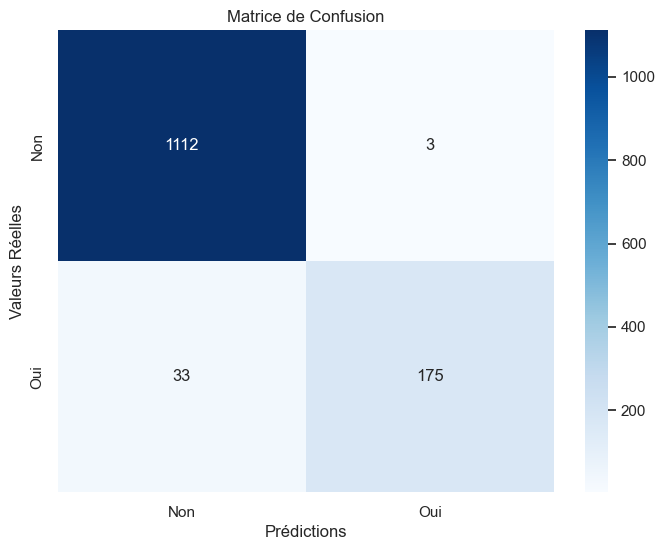

In [245]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

La matrice de confusion pour le modèle Random Forest présente les performances de prédiction de l'attrition des employés avec une grande clarté. Voici le détail :

- Vrais Négatifs (TN) : 1112 employés ont été correctement identifiés comme ne quittant pas l'entreprise, ce qui indique que le modèle est extrêmement précis pour détecter les cas de non-attrition.
- Faux Positifs (FP) : Seulement 3 employés ont été incorrectement prédits comme quittant l'entreprise alors qu'en réalité ils sont restés, ce qui montre une très faible erreur de Type I.
- Faux Négatifs (FN) : 33 employés ont été incorrectement prédits comme restant alors qu'ils ont effectivement quitté l'entreprise. Cela représente une erreur de Type II, où le modèle n'a pas détecté l'attrition.
- Vrais Positifs (VP) : 175 employés qui ont quitté l'entreprise ont été correctement identifiés comme tels.

Cette matrice révèle que le modèle Random Forest a une excellente capacité à reconnaître les employés qui resteront dans l'entreprise, avec un taux très élevé de vrais négatifs et un nombre très faible de faux positifs. La performance est également très bonne pour identifier les employés qui partent, avec un nombre élevé de vrais positifs par rapport aux faux négatifs, bien que cet aspect puisse encore être amélioré.

### ROC Curve

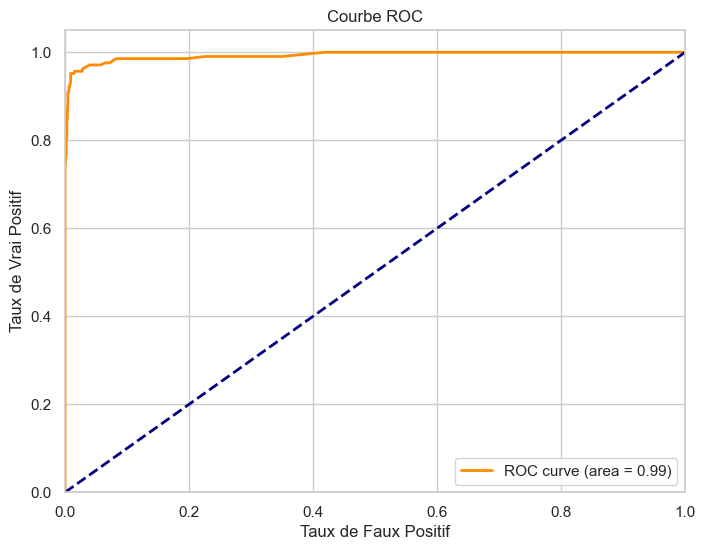

In [231]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

La courbe ROC affichée illustre de manière visuelle l'excellente performance du modèle Random Forest dans notre contexte de prédiction de l'attrition. La ligne orange représente la courbe ROC du modèle, tandis que la ligne pointillée bleue représente la performance d'un modèle aléatoire.

Courbe ROC : La courbe de notre modèle suit de très près le coin supérieur gauche, indiquant un taux élevé de vrais positifs et un faible taux de faux positifs à travers différents seuils de décision. Cela signifie que le modèle est capable de distinguer avec précision entre les employés qui quitteront et ceux qui resteront dans l'entreprise.

AUC de 0.99 : L'aire sous la courbe (AUC) est proche de la perfection. Une valeur de 0.99 sur une échelle de 0 à 1 indique que le modèle a une probabilité de 99% de correctement classer un employé positif (qui quitte) plus haut qu'un employé négatif (qui reste), ce qui est confirmé par la proximité de la courbe ROC avec le coin supérieur gauche et le bord supérieur du graphique.

Cette courbe ROC, couplée à une AUC de 0.99, suggère que le modèle est très performant et qu'il offre une confiance élevée dans ses prédictions. Dans la pratique, cela signifie que les stratégies de rétention des employés fondées sur les prédictions de ce modèle ont une grande chance de cibler correctement les individus à risque. Il est rare d'obtenir de tels résultats, ce qui peut aussi inciter à une vérification approfondie pour s'assurer qu'il n'y a pas de surajustement ou de biais dans le modèle ou les données.

### Conclusion

La performance globale du modèle Random Forest, illustrée par la courbe ROC, la matrice de confusion, et les métriques de précision, est nettement supérieure à celle que nous avons observée avec le modèle KNN.

Le Random Forest a démontré unbonne e capacile à distinguer entre les employés qui vont quitter l'entreprise et ceux qui vont rester, comme en témoigne son AUC presque parfaite. Les erreurs de classification sont minimales, et les mesures de précision et de rappel indiquent que le modèle est à la fois précis et sensible dans ses prédictions.

En comparaison, bien que le KNN ait fourni des résultats satisfaisants, le Random Forest se distingue par une performance supérieure et une fiabilité accrue. La différence entre les deux modèles pourrait être attribuée à la capacité du Random Forest à gérer les caractéristiques complexes et les interactions non linéaires entre elles, ce qui est souvent le cas dans les données réelles.